## Weather data visualization

In [1]:
import os
import yaml

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
from palettable.colorbrewer.sequential import Purples_9
from palettable.colorbrewer.sequential import GnBu_8
from palettable.colorbrewer.sequential import OrRd_6

In [49]:
# Read in processed data
df_wea = pd.read_csv('/home/disk/eos8/ach315/upscale/weadata/wea_summary_control_fixpd.csv', dtype={'site': str})
df_siteyears = pd.read_csv('/home/disk/eos8/ach315/upscale/weadata/siteyears_control_fixpd.csv', dtype={'site':str})
df_stations = pd.read_csv('/home/disk/eos8/ach315/upscale/weadata/stations_info_9110.csv', dtype={'USAF': str})

# Create df_sites
df_sites = df_stations[df_stations.USAF.isin(df_siteyears.site)][['USAF', 'NSRDB_LAT (dd)', 'NSRDB_LON(dd)']]
df_sites.columns = ['site', 'lat', 'lon']
df_sites['years'] = list(df_siteyears.groupby('site').count()['year'])

In [52]:
df_wea_grouped = df_wea.groupby('site').mean().reset_index()
df_wea_summary = pd.merge(df_wea_grouped, df_sites, on='site')

Text(-108, 22, 'siteyears: 1160')

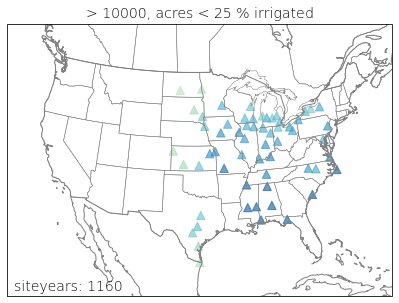

In [59]:
area = 10000/2.47
irri = 25

# Map out simulation sites
extent = [-123, -72, 19, 53]
fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(1,1,1, projection=ccrs.AlbersEqualArea(
    central_latitude=39.5, central_longitude=-98.35))
ax.scatter(df_wea_summary.lon, df_wea_all.lat,
           transform=ccrs.PlateCarree(), s=70, marker='^',
           c=df_wea_summary.precip, cmap=GnBu_8.mpl_colormap, 
           vmin=100, vmax=800, alpha=0.6)
ax.set_extent(extent)
ax.add_feature(cfeature.COASTLINE, edgecolor='grey')
ax.add_feature(cfeature.BORDERS, edgecolor='grey')
ax.add_feature(cfeature.STATES, edgecolor='grey', linewidth=0.5)
ax.set_title(f'> {int(area*2.47)}, acres < {irri} % irrigated',
             fontweight='light', fontsize=14)
ax.text(-108, 22, f'siteyears: {df_siteyears.shape[0]}',
        horizontalalignment='right', transform=ccrs.PlateCarree(),
        fontweight='light', fontsize=14)